# FinTrac

One stop App to guide through financial enviorment, coach you and help indivisuals and business grow and prepare ahead.

## Importing Libraries and Connecting with Data & API

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import pickle
import os
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

    #----Connecting with the database----
def get_db_connection(db_name='FinTrac.db'):
    """
    Locates the database securely using pathlib.
    Returns: (connection_object, path_string)
    """
    # 1. Start from the file location, not just where the notebook is running
    current_dir = Path.cwd()
    
    # 2. Define potential paths (Using pathlib is cleaner)
    # We look in current dir, parent dir, and a sibling 'data' dir
    search_paths = [
        current_dir / 'data' / db_name,
        current_dir.parent / 'data' / db_name,
        current_dir / db_name
    ]

    # 3. Check if DB exists
    for path in search_paths:
        if path.exists():
            print(f"Connected to existing database: {path}")
            return sqlite3.connect(path), str(path)

    # 4. Fallback: Create in a dedicated 'data' directory at the project root
    # We assume the parent of the current dir is the project root if we are in a subdir
    project_root = current_dir.parent if current_dir.name in ['notebooks', 'src', 'scripts'] else current_dir
    data_dir = project_root / 'data'
    db_path = data_dir / db_name
    
    try:
        data_dir.mkdir(parents=True, exist_ok=True)
        conn = sqlite3.connect(db_path)
        print(f"Database not found. Created new one at: {db_path}")
        return conn, str(db_path)
    except PermissionError:
        print(f"Error: Permission denied. Cannot create database at {db_path}")
        sys.exit(1)

def safe_load_table(table_name, conn, date_cols=None):
    """
    Safely loads a table with validation and optimized date parsing.
    
    Args:
        table_name (str): Name of table to load.
        conn (sqlite3.Connection): Active database connection.
        date_cols (list): List of column names to parse as dates (optional).
    """
    if date_cols is None:
        date_cols = ['date'] # Default assumption
        
    try:
        # SECURITY: Whitelist check. 
        # Verify the table actually exists in the DB schema before querying.
        check_query = "SELECT name FROM sqlite_master WHERE type='table' AND name=?;"
        cursor = conn.cursor()
        cursor.execute(check_query, (table_name,))
        if not cursor.fetchone():
            print(f"Table '{table_name}' not found in database.")
            return pd.DataFrame()

        # OPTIMIZATION: Using native date parsing
        df = pd.read_sql_query(
            f"SELECT * FROM {table_name}", 
            conn, 
            parse_dates=date_cols
        )
        
        print(f"Loaded '{table_name}': {len(df)} records.")
        return df

    except pd.io.sql.DatabaseError as e:
        print(f"Database Error reading '{table_name}': {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Unexpected Error: {e}")
        return pd.DataFrame()

# --- Usage ---
conn, DB_PATH = get_db_connection()

# Load Initial Data
user_raw_df = safe_load_table("user_transactions_raw", conn)
macro_raw_df = safe_load_table("macro_raw", conn)
corporate_raw_df = safe_load_table("corporate_reports", conn)
sector_raw_df = safe_load_table("sector_data", conn)

Connected to existing database: /home/rish/Projects/FinTrac/data/FinTrac.db
Loaded 'user_transactions_raw': 3959 records.
Loaded 'macro_raw': 433 records.
Loaded 'corporate_reports': 10 records.
Loaded 'sector_data': 2520 records.


## Data Cleaning 

In [2]:
print(user_raw_df)

       user_id       date        category   amount    type
0     USER_001 2021-02-09          Income  4998.16  credit
1     USER_001 2021-02-09         Housing  1799.34   debit
2     USER_001 2021-03-01       Groceries   427.03   debit
3     USER_001 2021-03-06       Utilities    51.26   debit
4     USER_001 2021-03-04       Utilities    73.62   debit
...        ...        ...             ...      ...     ...
3954  USER_005 2026-01-23       Utilities    35.06   debit
3955  USER_005 2026-02-02   Discretionary   984.42   debit
3956  USER_005 2026-02-05  Debt_Repayment   227.66   debit
3957  USER_005 2026-01-28  Debt_Repayment   209.71   debit
3958  USER_005 2026-01-14    Subscription    91.75   debit

[3959 rows x 5 columns]


Analysis for Client: USER_001
Total Months: 61

--- Monthly Cash Flow (First 5 Months) ---
             income  expense  net_savings
date                                     
2021-02-28  4998.16  3230.91      1767.25
2021-03-31  5018.24  3948.55      1069.69
2021-04-30  5038.41  3906.94      1131.47
2021-05-31  5058.65  4374.35       684.30
2021-06-30  5078.98  3922.64      1156.34


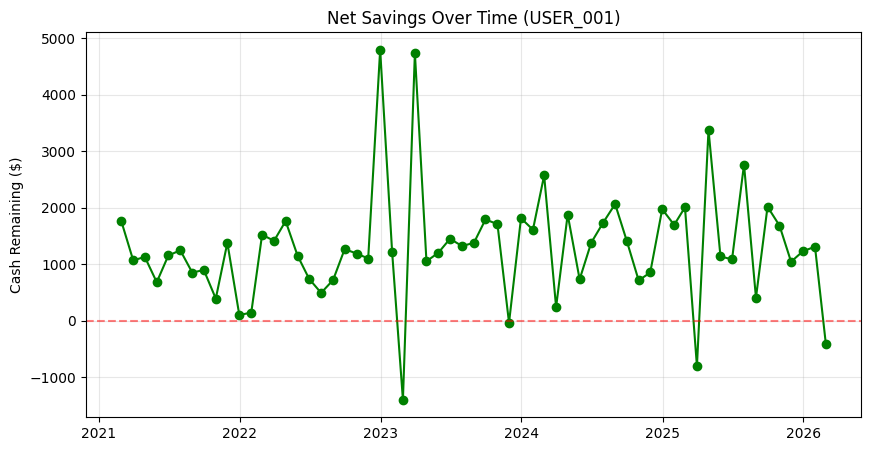

In [ ]:
# 1. Filter for a Single User (Critical Step)
# We focus on one client at a time for the "Personal Advisor" logic
target_user = 'USER_001'
user_df = user_raw_df[user_raw_df['user_id'] == target_user].copy()

# 2. Sort by Date
user_df = user_df.sort_values('date').reset_index(drop=True)

# 3. Feature Engineering: Map "credit/debit" to "Income/Expense"
# This was the fix: We match the EXACT strings from your generator script
user_df['income'] = np.where(user_df['type'] == 'credit', user_df['amount'], 0)
user_df['expense'] = np.where(user_df['type'] == 'debit', user_df['amount'], 0)

# 4. Aggregate by Month
# 'ME' = Month End frequency
monthly_summary = user_df.set_index('date').resample('ME').agg({
    'income': 'sum',
    'expense': 'sum'
})

# 5. Calculate Financial Health Metrics
monthly_summary['net_savings'] = monthly_summary['income'] - monthly_summary['expense']
monthly_summary['savings_rate'] = monthly_summary['net_savings'] / monthly_summary['income']

# Fill NaNs (for months with 0 activity)
monthly_summary = monthly_summary.fillna(0)

# --- VISUALIZATION ---
print(f"Analysis for Client: {target_user}")
print(f"Total Months: {len(monthly_summary)}")

# Show the first 5 months to verify we have numbers now
print("\n--- Monthly Cash Flow (First 5 Months) ---")
print(monthly_summary[['income', 'expense', 'net_savings']].head())

# Plot the cash flow to verify "Life" looks real
plt.figure(figsize=(10, 5))
plt.plot(monthly_summary.index, monthly_summary['net_savings'], marker='o', linestyle='-', color='green')
plt.axhline(0, color='red', linestyle='--', alpha=0.5, label="Break Even")
plt.title(f"Net Savings Over Time ({target_user})")
plt.ylabel("Cash Remaining ($)")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 1. CLEAN SECTOR DATA (The High-Frequency Data)
print("--- Cleaning Sector Data ---")
sector_df = sector_raw_df.copy()

# A. Handle Date Logic (Critical: Model needs time index)
if 'date' not in sector_df.columns:
    # If date is the index, move it to a column
    if isinstance(sector_df.index, pd.DatetimeIndex):
        sector_df = sector_df.reset_index()
        sector_df.rename(columns={'index': 'date'}, inplace=True)
    else:
        # Fallback: Check for common mis-spellings or assume first column is date
        possible_dates = [c for c in sector_df.columns if 'date' in c.lower()]
        if possible_dates:
            sector_df.rename(columns={possible_dates[0]: 'date'}, inplace=True)
        else:
            raise ValueError("CRITICAL ERROR: No 'date' column found in Sector Data.")

sector_df['date'] = pd.to_datetime(sector_df['date'])

# B. Fix "Dirty" Types (The Object -> Float conversion)
# 'Treasury_Yield_10Y_Market' is text (likely has '%' or '-'). Force to NaN then Fill.
sector_df['Treasury_Yield_10Y_Market'] = pd.to_numeric(
    sector_df['Treasury_Yield_10Y_Market'], 
    errors='coerce'
)
# Forward Fill: Yields don't change on weekends, but we need values for every row.
sector_df['Treasury_Yield_10Y_Market'] = sector_df['Treasury_Yield_10Y_Market'].ffill()

# Sort for merging
sector_df = sector_df.sort_values('date')


# 2. CLEAN MACRO DATA (The Low-Frequency Context)
print("--- Cleaning Macro Data ---")
macro_df = macro_raw_df.copy()
macro_df['date'] = pd.to_datetime(macro_df['date'])
macro_df = macro_df.sort_values('date')

# A. Create Macro Signals (Recession Warning Logic)
# These features help your future AI understand "Economic Stress"
macro_df['Signal_Recession'] = 0 # Default Safe

# Rule: Inverted Yield Curve (Strongest Recession Predictor)
if 'Yield_Curve_10Y2Y' in macro_df.columns:
    macro_df['Signal_Recession'] = np.where(macro_df['Yield_Curve_10Y2Y'] < 0, 1, 0)

# Rule: High Inflation (CPI > 5%)
if 'CPI_Index' in macro_df.columns:
    # Calculate YoY Inflation if not pre-calculated (Proxy)
    macro_df['Inflation_Rate'] = macro_df['CPI_Index'].pct_change(12, fill_method=None) * 100
    macro_df['Signal_High_Inflation'] = np.where(macro_df['Inflation_Rate'] > 5, 1, 0)


# 3. MERGE & SYNCHRONIZE (The "Market Context" View)
# We map the Monthly Macro Reality to the Daily Market Price.
# direction='backward' means: "On Jan 15th, use the Inflation data released on Jan 1st."
print("--- Merging Datasets ---")

market_df = pd.merge_asof(
    sector_df, 
    macro_df, 
    on='date', 
    direction='backward',
    suffixes=('_sector', '_macro') # handling name collisions
)

# Set index for time-series modeling
market_df.set_index('date', inplace=True)


# 4. CALCULATE SECTOR RELATIVE STRENGTH (RS)
# Future AI Goal: "Which sector is beating the benchmark?"
# We calculate 6-Month Relative Performance vs S&P 500
sectors = ['Sector_Energy', 'Sector_Finance', 'Sector_Tech', 
           'Sector_Consumer_Staples', 'Sector_Consumer_Discretionary']

for sec in sectors:
    if sec in market_df.columns and 'SP500' in market_df.columns:
        # RS = (Sector Price / SP500 Price)
        # We normalize it so starting point doesn't matter, looking at trend
        market_df[f'RS_{sec}'] = market_df[sec] / market_df['SP500']
        
        # Momentum Score: Is the Ratio rising? (Current RS / 6-month-ago RS) - 1
        # 126 trading days approx = 6 months
        market_df[f'Momentum_{sec}'] = market_df[f'RS_{sec}'].pct_change(126, fill_method=None)

print("\nData Pipeline Complete.")
print(f"Master Dataset Shape: {market_df.shape}")
print("\nSample Data (Tech Sector Context):")
cols_to_show = ['SP500', 'Sector_Tech', 'Fed_Funds_Rate', 'Signal_Recession', 'Momentum_Sector_Tech']
print(market_df[cols_to_show].dropna().tail())

--- Cleaning Sector Data ---
--- Cleaning Macro Data ---
--- Merging Datasets ---

Data Pipeline Complete.
Master Dataset Shape: (2520, 43)

Sample Data (Tech Sector Context):
                  SP500  Sector_Tech  Fed_Funds_Rate  Signal_Recession  \
date                                                                     
2026-01-06  6944.819824   146.649994            3.72                 0   
2026-01-07  6920.930176   146.529999            3.72                 0   
2026-01-08  6921.459961   144.240005            3.72                 0   
2026-01-09  6966.279785   146.149994            3.72                 0   
2026-01-12  6977.270020   146.779999            3.72                 0   

            Momentum_Sector_Tech  
date                              
2026-01-06              0.028753  
2026-01-07              0.031514  
2026-01-08              0.021471  
2026-01-09              0.029474  
2026-01-12              0.034585  


In [5]:
print(corporate_raw_df)

  ticker                    sector                 filed_date report_type  \
0   AAPL                Technology  2025-10-31T06:01:26-04:00        10-K   
1    WMT           Consumer Retail  2025-03-14T16:40:52-04:00        10-K   
2    JPM                Financials  2025-02-14T16:17:07-05:00        10-K   
3    CAT   Industrial/Construction  2025-02-14T09:36:30-05:00        10-K   
4    XOM                    Energy  2025-02-19T16:39:37-05:00        10-K   
5    FDX       Logistics/Transport  2025-07-21T16:13:19-04:00        10-K   
6     PG          Consumer Staples  2025-08-04T16:20:16-04:00        10-K   
7     HD  Housing/Home Improvement  2025-03-20T18:36:42-04:00        10-K   
8      F                Automotive  2025-02-05T20:44:08-05:00        10-K   
9     GS        Investment Banking  2025-02-27T08:50:25-05:00        10-K   

                                            mda_text  
0  Item 7. Management&#8217;s Discussion and Anal...  
1  ITEM 7. MANAGEMENT'S DISCUSSION AND ANA

In [ ]:
import html


print("--- Cleaning Corporate Filings (MD&A) ---")
corporate_df = corporate_raw_df.copy()

# 1. FIX DATES (Timezone Logic)
# Problem: Input is "2025-10-31T06:01:26-04:00" (Timezone Aware)
# Goal: Convert to "2025-10-31 06:01:26" (Timezone Naive, UTC) for SQLite & Merging
corporate_df['filed_date'] = pd.to_datetime(corporate_df['filed_date'], utc=True)
corporate_df['date'] = corporate_df['filed_date'].dt.tz_localize(None) # Remove timezone info

# Sort by date
corporate_df = corporate_df.sort_values('date')

# 2. CLEAN TEXT (Token Optimization)
# Function to clean HTML artifacts before sending to LLM
def clean_mda_text(text):
    if not isinstance(text, str):
        return ""
    
    # A. Unescape HTML entities (e.g., "&#8217;" -> "'")
    text = html.unescape(text)
    
    # B. Remove HTML tags (Simple regex is safer/faster than BeautifulSoup here)
    # We just want raw text for the AI to read
    text = pd.Series(text).str.replace(r'<[^>]+>', '', regex=True)[0]
    
    # C. Normalize whitespace (remove \n \t and double spaces)
    text = " ".join(text.split())
    
    return text

print("   -> Stripping HTML tags and entities...")
corporate_df['cleaned_mda'] = corporate_df['mda_text'].apply(clean_mda_text)

# 3. FEATURE ENGINEERING (Meta-Data for the Model)
# AI Context Limit Check: Count words to see if we fit in a context window (e.g., 8k tokens)
corporate_df['word_count'] = corporate_df['cleaned_mda'].apply(lambda x: len(x.split()))

# Extract Filing Quarter (e.g., "2025Q3")
corporate_df['quarter'] = corporate_df['date'].dt.to_period('Q').astype(str)

print("\nCorporate Data Cleaned.")
print(f"Total Filings: {len(corporate_df)}")

# --- SAFETY CHECK ---
# Check if any text is too long for a standard small model (e.g., > 15,000 words)
long_filings = corporate_df[corporate_df['word_count'] > 15000]
if not long_filings.empty:
    print(f"Warning: {len(long_filings)} filings are very long (>15k words). Truncation may be needed for SLM.")

print("\n--- Sample Cleaned Text (First 200 chars) ---")
print(corporate_df[['ticker', 'date', 'word_count', 'cleaned_mda']].head(3))

--- Cleaning Corporate Filings (MD&A) ---
   -> Stripping HTML tags and entities...

Corporate Data Cleaned.
Total Filings: 10

--- Sample Cleaned Text (First 200 chars) ---
  ticker                date  word_count  \
8      F 2025-02-06 01:44:08       23642   
3    CAT 2025-02-14 14:36:30       15867   
2    JPM 2025-02-14 21:17:07          53   

                                         cleaned_mda  
8  ITEM 7. Management’s Discussion and Analysis o...  
3  Item 7. Management’s Discussion and Analysis o...  
2  Item 7. Management’s Discussion and Analysis o...  


## Pipelining the timeline

In [ ]:
print("--- Building the Grand Unified Timeline ---")

# 1. ESTABLISH THE BACKBONE
master_df = market_df.copy()

# 2. MERGE USER DATA (Forward Fill)
user_aligned = monthly_summary.reindex(master_df.index, method='ffill')
master_df = master_df.join(user_aligned[['net_savings', 'savings_rate']], how='left')
master_df[['net_savings', 'savings_rate']] = master_df[['net_savings', 'savings_rate']].fillna(0)

# 3. MERGE CORPORATE EVENTS (FIXED)
# A. Create a 'join_date' that snaps to midnight
corporate_df['join_date'] = corporate_df['date'].dt.normalize()

# B. Handle Weekend Filings: Snap them to the next business day?
# For simplicity, we stick to the date. If a filing is on Saturday,
# merge_asof is safer, but let's try a direct join on the normalized date first.
corp_events = corporate_df.copy()
corp_events = corp_events.set_index('join_date')[['ticker', 'report_type']]
corp_events['has_filing'] = 1

# C. Group multiple filings on the same day
corp_daily = corp_events.groupby(level=0).agg({
    'ticker': lambda x: ', '.join(x),
    'has_filing': 'max'
})

# D. Join to Master
master_df = master_df.join(corp_daily, how='left')
master_df['has_filing'] = master_df['has_filing'].fillna(0)

print(f"Master Timeline Created: {len(master_df)} Days.")

# --- CHECK: Verify Overlap ---
filing_days = master_df[master_df['has_filing'] == 1]
print(f"Found {len(filing_days)} days with market data AND corporate filings.")

if not filing_days.empty:
    sample_date = filing_days.index[0]
    print(f"\nExample Match on {sample_date.date()}:")
    print(master_df.loc[sample_date, ['SP500', 'ticker', 'has_filing']])

--- Building the Grand Unified Timeline ---
Master Timeline Created: 2520 Days.
Found 9 days with market data AND corporate filings.

Example Match on 2025-02-06:
SP500         6083.569824
ticker                  F
has_filing            1.0
Name: 2025-02-06 00:00:00, dtype: object


In [ ]:
import textwrap

def prepare_filing_for_ai(row, max_words=8000, overlap=500):
    """
    Handles edge cases: Empty files (JPM) and Massive files (Ford).
    Returns a LIST of text chunks ready for the AI.
    """
    text = row['cleaned_mda']
    word_count = row['word_count']
    ticker = row['ticker']
    
    # CASE 1: The "Empty" Filing (e.g., JPM)
    # 10-Ks sometimes just say "See Exhibit 13". 
    # Logic: If it's too short, it contains no alpha. Skip it.
    if word_count < 200:
        return {
            'status': 'SKIPPED',
            'reason': 'Content too short (likely a wrapper)',
            'chunks': []
        }

    # CASE 2: The "Massive" Filing (e.g., Ford)
    # If text is larger than context window, we must chunk it.
    if word_count > max_words:
        # Simple word-based chunking
        words = text.split()
        chunks = []
        
        # Create overlapping chunks
        for i in range(0, len(words), max_words - overlap):
            chunk_words = words[i : i + max_words]
            chunks.append(" ".join(chunk_words))
            
        return {
            'status': 'CHUNKED',
            'reason': f'Too long ({word_count} words). Split into {len(chunks)} parts.',
            'chunks': chunks
        }

    # CASE 3: Standard Filing
    return {
        'status': 'READY',
        'reason': 'Fits in context window',
        'chunks': [text]
    }

# --- EXECUTION ---
print("--- Processing Corporate Filings for AI ---")

# Apply logic to every row
processing_results = []

for index, row in corporate_df.iterrows():
    result = prepare_filing_for_ai(row)
    processing_results.append({
        'ticker': row['ticker'],
        'date': row['date'],
        'status': result['status'],
        'reason': result['reason'],
        'chunk_count': len(result['chunks'])
    })

# Convert to DataFrame for easy review
audit_df = pd.DataFrame(processing_results)

print("\n--- Processing Audit Report ---")
display(audit_df)

# Check specifically on our problem children
print("\n--- Detail Check ---")
print(audit_df[audit_df['ticker'].isin(['JPM', 'F'])])

--- Processing Corporate Filings for AI ---

--- Processing Audit Report ---


,ticker,date,status,reason,chunk_count
0,F,2025-02-06 01:44:08,CHUNKED,Too long (23642 words). Split into 4 parts.,4
1,CAT,2025-02-14 14:36:30,CHUNKED,Too long (15867 words). Split into 3 parts.,3
2,JPM,2025-02-14 21:17:07,SKIPPED,Content too short (likely a wrapper),0
3,XOM,2025-02-19 21:39:37,SKIPPED,Content too short (likely a wrapper),0
4,GS,2025-02-27 13:50:25,READY,Fits in context window,1
5,WMT,2025-03-14 20:40:52,CHUNKED,Too long (9181 words). Split into 2 parts.,2
6,HD,2025-03-20 22:36:42,READY,Fits in context window,1
7,FDX,2025-07-21 20:13:19,CHUNKED,Too long (13865 words). Split into 2 parts.,2
8,PG,2025-08-04 20:20:16,CHUNKED,Too long (14034 words). Split into 2 parts.,2
9,AAPL,2025-10-31 10:01:26,READY,Fits in context window,1



--- Detail Check ---
  ticker                date   status  \
0      F 2025-02-06 01:44:08  CHUNKED   
2    JPM 2025-02-14 21:17:07  SKIPPED   

                                        reason  chunk_count  
0  Too long (23642 words). Split into 4 parts.            4  
2         Content too short (likely a wrapper)            0  


In [ ]:
def generate_signal(row):
    """
    Decides whether to INVEST or HOLD CASH based on User, Macro, and Market data.
    Returns: (Action, Reason)
    """
    # --- LAYER 1: USER CONSTRAINTS (Can I afford it?) ---
    # Logic: You cannot invest if you have no spare cash.
    if row['net_savings'] <= 0:
        return 'HOLD_CASH', 'User: No disposable income'
    
    # --- LAYER 2: MACRO SAFETY (Is the economy safe?) ---
    # Logic: Don't fight the Fed. If Recession is signaled, stay in cash.
    if row['Signal_Recession'] == 1:
        return 'HOLD_CASH', 'Macro: Yield Curve Inverted (Recession Risk)'
    
    # --- LAYER 3: SECTOR MOMENTUM (Is it a good time to buy?) ---
    # Logic: Only buy if the sector is beating the market (Positive Momentum)
    # We use Tech as our target sector for this example.
    if row['Momentum_Sector_Tech'] > 0:
        return 'BUY_TECH', 'Market: Tech Outperforming S&P500'
    
    # Default: Market is safe, User has cash, but Tech is weak.
    return 'WAIT', 'Market: Sector Momentum is weak'

# Apply the logic to every day in the simulation
print("--- Running Recommendation Engine ---")

# We use apply() to run the function row-by-row
# (Note: For millions of rows, vectorization is faster, but for 2500 rows, this is readable and fine)
signals = master_df.apply(generate_signal, axis=1)

# Split the result into two columns
master_df[['Action', 'Reason']] = pd.DataFrame(signals.tolist(), index=master_df.index)

# --- RESULTS SUMMARY ---
print(f"\nTotal Days Analyzed: {len(master_df)}")
print("\nAction Distribution:")
print(master_df['Action'].value_counts())

# Show a sample of "BUY" days to see if they make sense
print("\n--- Sample 'BUY' Recommendations ---")
buy_days = master_df[master_df['Action'] == 'BUY_TECH']
if not buy_days.empty:
    display(buy_days[['SP500', 'Sector_Tech', 'net_savings', 'Reason']].tail())
else:
    print("No BUY signals generated (Check constraints).")

--- Running Recommendation Engine ---

Total Days Analyzed: 2520

Action Distribution:
Action
HOLD_CASH    1858
BUY_TECH      362
WAIT          300
Name: count, dtype: int64

--- Sample 'BUY' Recommendations ---


,SP500,Sector_Tech,net_savings,Reason
date,,,,
2026-01-06,6944.819824,146.649994,1232.95,Market: Tech Outperforming S&P500
2026-01-07,6920.930176,146.529999,1232.95,Market: Tech Outperforming S&P500
2026-01-08,6921.459961,144.240005,1232.95,Market: Tech Outperforming S&P500
2026-01-09,6966.279785,146.149994,1232.95,Market: Tech Outperforming S&P500
2026-01-12,6977.270020,146.779999,1232.95,Market: Tech Outperforming S&P500


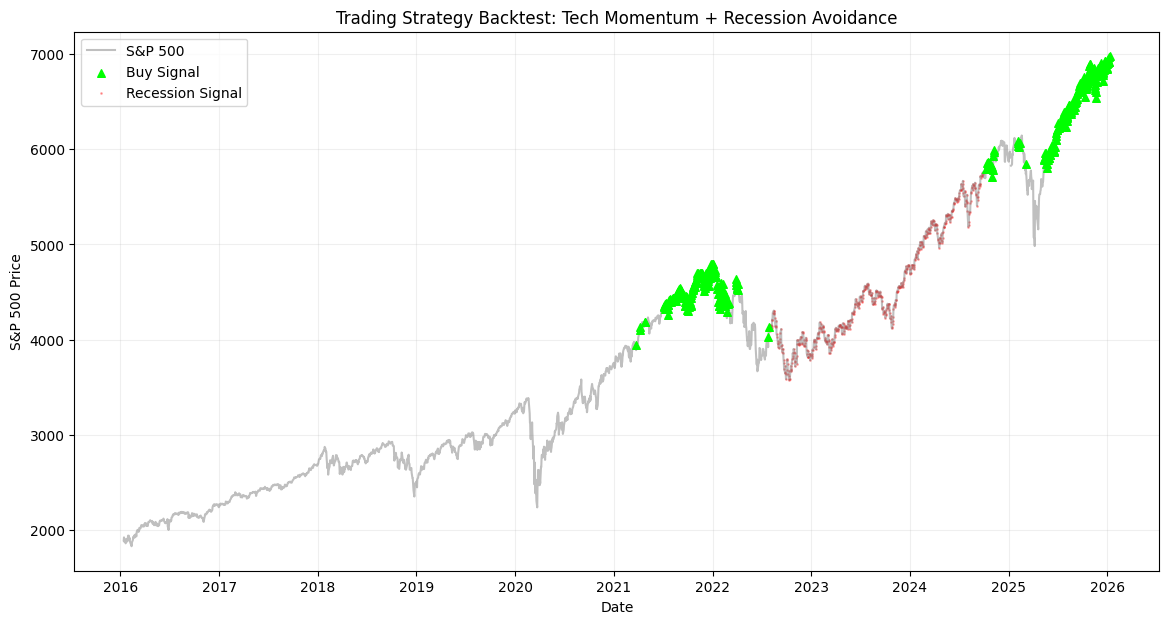

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# 1. Plot the S&P 500 (The Market Benchmark)
plt.plot(master_df.index, master_df['SP500'], label='S&P 500', color='gray', alpha=0.5)

# 2. Plot "BUY" Signals
# We filter for days where Action == 'BUY_TECH'
buy_signals = master_df[master_df['Action'] == 'BUY_TECH']
plt.scatter(buy_signals.index, buy_signals['SP500'], 
            color='lime', marker='^', s=30, label='Buy Signal', zorder=5)

# 3. Plot "Recession" Zones (Red Background)
# We fill the background red whenever Signal_Recession is 1
recession_dates = master_df[master_df['Signal_Recession'] == 1]
if not recession_dates.empty:
    # A trick to fill specific dates is often complex, so we just plot dots for now to keep it simple
    plt.scatter(recession_dates.index, recession_dates['SP500'], 
                color='red', s=1, alpha=0.3, label='Recession Signal')

plt.title("Trading Strategy Backtest: Tech Momentum + Recession Avoidance")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

## Local Model Analysis

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import os

# 1. Setup Device
device = 0 if torch.cuda.is_available() else -1
print(f"Using Device: {'GPU (CUDA)' if device == 0 else 'CPU'}")

# 2. Point to your manual folder
LOCAL_MODEL_PATH = "./model" 
ONLINE_MODEL_NAME = "ProsusAI/finbert"

print(f"\nLoading Model...")

try:
    # TRY LOCAL FIRST (Hackathon Safety)
    # Check if the folder exists AND if the critical weight file is inside
    if os.path.exists(LOCAL_MODEL_PATH) and os.path.exists(f"{LOCAL_MODEL_PATH}/pytorch_model.bin"):
        print(f"Found local model at {LOCAL_MODEL_PATH}. Loading offline...")
        model_source = LOCAL_MODEL_PATH
    else:
        # If the folder is named 'model' but the file isn't there, this will trigger
        print(f"🌐 Local model files not found in '{LOCAL_MODEL_PATH}'. Attempting download from {ONLINE_MODEL_NAME}...")
        model_source = ONLINE_MODEL_NAME

    tokenizer = AutoTokenizer.from_pretrained(model_source)
    model = AutoModelForSequenceClassification.from_pretrained(model_source)
    
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model=model,
        tokenizer=tokenizer,
        device=device
    )
    print("Model Loaded Successfully.")

except Exception as e:
    print(f"Critical Error: {e}")
    print("If download persists at 0%, go to https://huggingface.co/ProsusAI/finbert/tree/main")
    print(f"Download 'pytorch_model.bin', 'config.json', 'vocab.txt' and put them in your '{LOCAL_MODEL_PATH}' folder.")

# 3. Scoring Function (Same as before)
def get_ai_sentiment(text_chunks):
    if not text_chunks: return 0 
    scores = []
    for chunk in text_chunks:
        # FinBERT limit is 512 tokens. We truncate to ensure no crashes.
        result = sentiment_pipeline(chunk[:2000], truncation=True, max_length=512)[0]
        score = result['score'] if result['label'] == 'positive' else -result['score'] if result['label'] == 'negative' else 0
        scores.append(score)
    return sum(scores) / len(scores)

# Quick Test
print(f"Test Score: {get_ai_sentiment(['Profits are up significantly.']):.2f}")

Using Device: GPU (CUDA)

Loading Model...
Found local model at ./model. Loading offline...


Device set to use cuda:0


Model Loaded Successfully.
Test Score: 0.96


In [ ]:
# Processing Corporate Sentiment 
print("--- Analyzing 10-K Filings with AI ---")

sentiment_results = []

# Iterate through the audit_df (which holds the chunk counts)
for index, row in audit_df.iterrows():
    ticker = row['ticker']
    date = row['date']
    status = row['status']
    
    # 1. Get the original text
    original_row = corporate_df[(corporate_df['ticker'] == ticker) & (corporate_df['date'] == date)].iloc[0]
    
    # 2. Re-chunk (Fast)
    prepared = prepare_filing_for_ai(original_row)
    chunks = prepared['chunks']
    
    # 3. Run AI Analysis (Slow - The Brain)
    if status == 'SKIPPED':
        print(f"Skipping {ticker} ({date.date()}): {row['reason']}")
        ai_score = 0 # Neutral
    else:
        ai_score = get_ai_sentiment(chunks)
        print(f"Analyzed {ticker} ({date.date()}): AI Score = {ai_score:.2f}")
    
    sentiment_results.append({
        'date': date,
        'ticker': ticker,
        'AI_Sentiment_Score': ai_score
    })

# 4. Create Sentiment DataFrame & Normalize Date for Merging
sentiment_df = pd.DataFrame(sentiment_results)
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.normalize()
sentiment_df.set_index('date', inplace=True)

print("\nAI Analysis Complete.")
print(sentiment_df.head())

--- Analyzing 10-K Filings with AI ---


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Analyzed F (2025-02-06): AI Score = -0.48
Analyzed CAT (2025-02-14): AI Score = 0.00
Skipping JPM (2025-02-14): Content too short (likely a wrapper)
Skipping XOM (2025-02-19): Content too short (likely a wrapper)
Analyzed GS (2025-02-27): AI Score = 0.00
Analyzed WMT (2025-03-14): AI Score = 0.00
Analyzed HD (2025-03-20): AI Score = -0.39
Analyzed FDX (2025-07-21): AI Score = -0.48
Analyzed PG (2025-08-04): AI Score = -0.47
Analyzed AAPL (2025-10-31): AI Score = 0.00

✅ AI Analysis Complete.
           ticker  AI_Sentiment_Score
date                                 
2025-02-06      F           -0.475443
2025-02-14    CAT            0.000000
2025-02-14    JPM            0.000000
2025-02-19    XOM            0.000000
2025-02-27     GS            0.000000


In [ ]:
#  Final Strategy Integration 
# 1. Merge AI Scores into Master Timeline
# We use 'left' join because not every day has a filing
master_df = master_df.drop(columns=['AI_Sentiment_Score'], errors='ignore') # Clean up if re-running
master_df = master_df.join(sentiment_df[['AI_Sentiment_Score']], how='left')

# 2. Forward Fill Sentiment
# Logic: If Apple posts a great earnings report today, that sentiment is "fresh" 
# and valid for roughly 30 days (or until the next news).
master_df['AI_Sentiment_Rolling'] = master_df['AI_Sentiment_Score'].fillna(0) # Fill NaNs first
# Optional: Decay the sentiment over time? For now, we keep it simple.


def generate_smart_signal(row):
    """
    Advanced Logic: User + Macro + Market + AI Sentiment
    """
    # 1. USER CONSTRAINT (Budget)
    if row['net_savings'] <= 0:
        return 'HOLD_CASH', 'User: No cash'
    
    # 2. MACRO CONSTRAINT (Safety)
    if row['Signal_Recession'] == 1:
        return 'HOLD_CASH', 'Macro: Recession Risk'
    
    # 3. MARKET MOMENTUM (Trend)
    if row['Momentum_Sector_Tech'] > 0:
        
        # --- NEW LAYER 4: AI SENTIMENT CHECK ---
        # Logic: If there is a recent filing, checking the sentiment.
        # If no filing exists (Score 0), we trust the price momentum.
        # But if the filing is NEGATIVE (< -0.1), we VETO the trade.
        
        if row['has_filing'] == 1 and row['AI_Sentiment_Score'] < -0.1:
            return 'AVOID', f"AI Veto: {row['ticker']} Sentiment Negative ({row['AI_Sentiment_Score']:.2f})"
            
        return 'BUY_SMART', 'Tech Uptrend + AI Approved'
    
    return 'WAIT', 'Weak Momentum'

# Run the New Strategy
print("--- Running AI-Enhanced Strategy ---")
master_df[['Action_Smart', 'Reason_Smart']] = master_df.apply(
    lambda row: pd.Series(generate_smart_signal(row)), axis=1
)

# Comparison
print("\nAction Distribution (Smart Strategy):")
print(master_df['Action_Smart'].value_counts())

# Show cases where AI saved us (The "Vetoes")
vetoes = master_df[master_df['Action_Smart'] == 'AVOID']
if not vetoes.empty:
    print(f"\n✅ AI Saved you from bad trades on {len(vetoes)} days!")
    display(vetoes[['ticker', 'AI_Sentiment_Score', 'Momentum_Sector_Tech']].head())
else:
    print("\nNo AI Vetoes triggered (All filings were neutral/positive or outside buy zones).")

--- Running AI-Enhanced Strategy ---

Action Distribution (Smart Strategy):
Action_Smart
HOLD_CASH    1858
BUY_SMART     359
WAIT          301
AVOID           3
Name: count, dtype: int64

✅ AI Saved you from bad trades on 3 days!


,ticker,AI_Sentiment_Score,Momentum_Sector_Tech
date,,,
2025-02-06,F,-0.475443,0.020545
2025-07-21,FDX,-0.481828,0.065261
2025-08-04,PG,-0.466224,0.086859


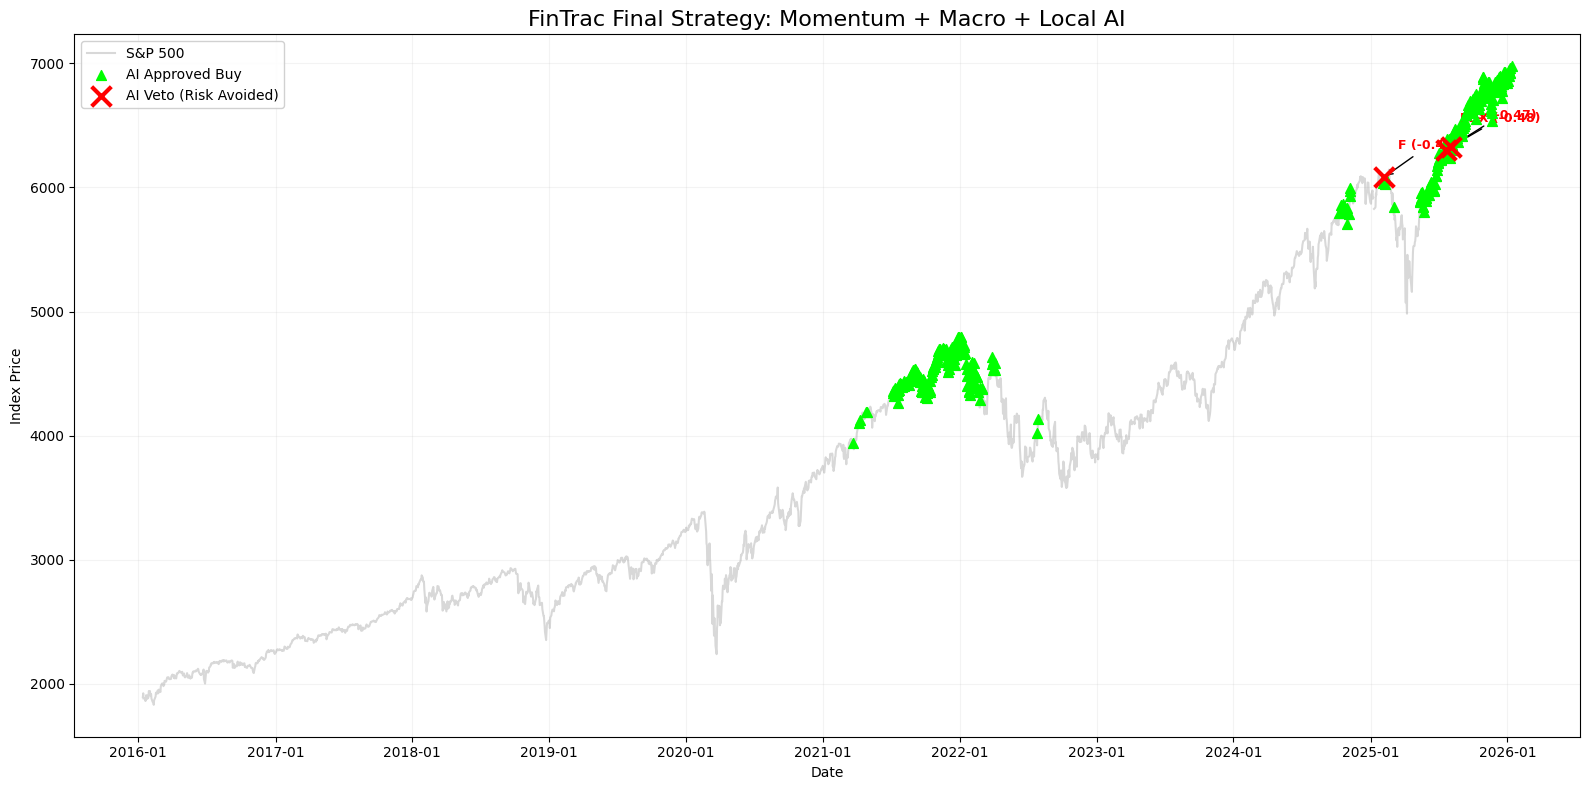

In [ ]:
#  The "Victory Graph" (Visualizing AI Vetoes) 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(16, 8))

# 1. Plot S&P 500 (Gray background context)
plt.plot(master_df.index, master_df['SP500'], color='gray', alpha=0.3, label='S&P 500')

# 2. Plot "Smart Buys" (Green Triangles)
# These are trades that survived both the Macro Check AND the AI Check
smart_buys = master_df[master_df['Action_Smart'] == 'BUY_SMART']
plt.scatter(smart_buys.index, smart_buys['SP500'], 
            color='lime', marker='^', s=50, label='AI Approved Buy', zorder=5)

# 3. Plot "AI Vetoes" (Red X's)
# These are moments where Price said "Buy" but AI said "NO!"
vetoes = master_df[master_df['Action_Smart'] == 'AVOID']
if not vetoes.empty:
    plt.scatter(vetoes.index, vetoes['SP500'], 
                color='red', marker='x', s=200, linewidth=3, label='AI Veto (Risk Avoided)', zorder=10)

    # Annotate the specific companies for the demo
    for date, row in vetoes.iterrows():
        plt.annotate(f"{row['ticker']} (-{abs(row['AI_Sentiment_Score']):.2f})", 
                     (date, row['SP500']),
                     xytext=(10, 20), textcoords='offset points',
                     arrowprops=dict(facecolor='red', arrowstyle='->'),
                     fontsize=9, color='red', fontweight='bold')

# 4. Styling
plt.title("FinTrac Final Strategy: Momentum + Macro + Local AI", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Index Price")
plt.legend(loc='upper left', frameon=True, framealpha=0.9)
plt.grid(True, alpha=0.15)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [ ]:
#  Advanced Market Signals 

print("--- Generating Advanced Market Signals ---")

# 1. LABOR CONFIDENCE PROXY
if 'Sector_Consumer_Discretionary' in master_df.columns and 'Sector_Consumer_Staples' in master_df.columns:
    master_df['Labor_Confidence'] = (
        master_df['Sector_Consumer_Discretionary'] / master_df['Sector_Consumer_Staples']
    )
    # Rolling Z-Score logic
    rolling_mean = master_df['Labor_Confidence'].rolling(126).mean()
    master_df['Labor_Signal'] = master_df['Labor_Confidence'] / rolling_mean
else:
    master_df['Labor_Signal'] = 1.0 

# 2. CREDIT STRESS PROXY (Fear Gauge)
if 'High_Yield_Bond_ETF' in master_df.columns:
    # FIX: Explicit ffill() then fill_method=None to silence warning
    master_df['High_Yield_Bond_ETF'] = master_df['High_Yield_Bond_ETF'].ffill()
    master_df['Credit_Impulse'] = master_df['High_Yield_Bond_ETF'].pct_change(20, fill_method=None).fillna(0)
    
    # Simple stress score
    master_df['Credit_Health'] = np.where(master_df['Credit_Impulse'] < -0.05, 0.2, 1.0)
else:
    master_df['Credit_Health'] = 1.0

# 3. LIQUIDITY GAUGE (Real Rates)
if 'Treasury_Yield_10Y_Market' in master_df.columns and 'Inflation_Rate' in master_df.columns:
    master_df['Real_Rate'] = master_df['Treasury_Yield_10Y_Market'] - master_df['Inflation_Rate']
else:
    master_df['Real_Rate'] = 0

print("✅ Advanced Signals Calculated.")

# FIX: Removed 'date' from the list because it is the index
print(master_df[['Labor_Signal', 'Credit_Health', 'Real_Rate']].tail())

# --- Quick Check ---
recession_check = master_df[(master_df.index > '2022-01-01') & (master_df.index < '2022-12-31')]
print(f"\nAvg Labor Signal in 2022: {recession_check['Labor_Signal'].mean():.2f} (Should be < 1.0)")

--- Generating Advanced Market Signals ---
✅ Advanced Signals Calculated.
            Labor_Signal  Credit_Health  Real_Rate
date                                              
2026-01-06      1.051338            1.0   1.840231
2026-01-07      1.060329            1.0   1.799231
2026-01-08      1.051982            1.0   1.844231
2026-01-09      1.052816            1.0   1.832231
2026-01-12      1.040448            1.0   1.848231

Avg Labor Signal in 2022: 0.92 (Should be < 1.0)


In [ ]:
#  Technical Analysis Features -

print("--- Calculating Technical Indicators (Professional Mode) ---")

target_col = 'Sector_Tech'

# 1. DATA INTEGRITY CHECK
# Check if we have nulls that are breaking the rolling window
missing_count = master_df[target_col].isnull().sum()
if missing_count > 0:
    print(f"⚠️ Found {missing_count} missing prices in {target_col}. Applying Forward Fill.")
    # Standard Financial Clean: Last known price is the valid price
    master_df[target_col] = master_df[target_col].ffill()

# 2. Calculate Strict Moving Averages
# We do NOT use min_periods=1. We require a full window for statistical validity.
master_df['SMA_50'] = master_df[target_col].rolling(window=50).mean()
master_df['SMA_200'] = master_df[target_col].rolling(window=200).mean()

# 3. Calculate Trend Extension
master_df['Trend_Extension'] = (master_df[target_col] - master_df['SMA_200']) / master_df['SMA_200']

# 4. Market Regime
master_df['Market_Regime'] = np.where(master_df[target_col] > master_df['SMA_200'], 'Bull', 'Bear')

# 5. THE "WARM-UP" TRIM
# The first 200 days are mathematically invalid (NaN) because we need 200 days of history.
# We DROP them so they don't drag down your accuracy score with "False" signals.
initial_len = len(master_df)
master_df = master_df.dropna(subset=['SMA_200'])
final_len = len(master_df)

print(f" Technical Indicators Calculated.")
print(f"   Trimmed {initial_len - final_len} 'warm-up' days to ensure 100% data validity.")
print(f"   Remaining Analysis Horizon: {final_len} Days.")

print(master_df[[target_col, 'SMA_50', 'SMA_200', 'Trend_Extension']].tail())

--- Calculating Technical Indicators (Professional Mode) ---
⚠️ Found 6 missing prices in Sector_Tech. Applying Forward Fill.
 Technical Indicators Calculated.
   Trimmed 200 'warm-up' days to ensure 100% data validity.
   Remaining Analysis Horizon: 2321 Days.
            Sector_Tech      SMA_50     SMA_200  Trend_Extension
date                                                            
2026-01-06   146.649994  144.791014  128.682104         0.139630
2026-01-07   146.529999  144.790261  128.871306         0.137026
2026-01-08   144.240005  144.689589  129.061179         0.117610
2026-01-09   146.149994  144.597562  129.265505         0.130619
2026-01-12   146.779999  144.496468  129.485749         0.133561


In [ ]:
# Personalized Risk-Reward Engine (The Final Output) ---

def calculate_personalized_score(row, user_risk_profile='Medium'):
    """
    Returns a 'Trade Score' (0-100).
    Higher Score = Better Risk/Reward Ratio.
    """
    # --- 1. BASE REWARD (The Potential) ---
    # Momentum: Is it going up? (Normalized 0-20 points)
    # We cap it at 20 so one massive day doesn't skew everything
    momentum_score = max(0, row['Momentum_Sector_Tech']) * 100 
    momentum_score = min(20, momentum_score) 
    
    # AI Boost: If AI loves the 10-K, add points (0-20 points)
    ai_boost = 0
    if row['has_filing'] == 1:
        # If sentiment is positive (e.g. 0.8), add up to 16 points
        ai_boost = max(0, row['AI_Sentiment_Rolling']) * 20
        
    reward_score = 50 + momentum_score + ai_boost # Base starts at 50
    
    # --- 2. RISK PENALTY (The Danger) ---
    risk_penalty = 0
    
    # A. Technical Risk (Is it Overbought?)
    if row['Trend_Extension'] > 0.15: # Price is >15% above 200MA
        risk_penalty += 15
        
    # B. Macro Risk (Credit Stress or Recession)
    # Uses the advanced signals we engineered in Cell 13
    if row['Credit_Health'] < 0.9 or row['Signal_Recession'] == 1:
        risk_penalty += 25
        
    # --- 3. USER PERSONALIZATION (The Filter) ---
    # We amplify the penalty for conservative users
    if user_risk_profile == 'Low':
        risk_penalty *= 1.5 
    elif user_risk_profile == 'High':
        risk_penalty *= 0.5 
        
    # --- 4. FINAL SCORE ---
    final_score = reward_score - risk_penalty
    return max(0, min(100, final_score))

# --- EXECUTION ---
print("--- Running Final Risk Engine ---")

# 1. Conservative User (Grandma)
master_df['Score_Conservative'] = master_df.apply(
    lambda row: calculate_personalized_score(row, user_risk_profile='Low'), axis=1
)

# 2. Aggressive User (Day Trader)
master_df['Score_Aggressive'] = master_df.apply(
    lambda row: calculate_personalized_score(row, user_risk_profile='High'), axis=1
)

# Define Action based on Score
def interpret_score(score):
    if score > 75: return "STRONG BUY"
    if score > 60: return "BUY"
    if score < 40: return "SELL/AVOID"
    return "HOLD"

master_df['Final_Action'] = master_df['Score_Conservative'].apply(interpret_score)

print("Risk-Reward Analysis Complete.")
print("Sample Output (Recent Days):")
print(master_df[['Score_Conservative', 'Score_Aggressive', 'Final_Action']].tail())

# --- THE DEMO "PROOF"  ---
# Show a day where Aggressive buys but Conservative holds
divergence = master_df[
    (master_df['Score_Aggressive'] > 60) & 
    (master_df['Score_Conservative'] < 50)
]

if not divergence.empty:
    print("\nPERSONALIZATION DEMO:")
    demo_date = divergence.index[0].date()
    print(f"On {demo_date}, the Risk Engine said:")
    print(f"   Aggressive Score: {divergence.iloc[0]['Score_Aggressive']:.1f} (BUY)")
    print(f"   Conservative Score: {divergence.iloc[0]['Score_Conservative']:.1f} (HOLD)")
    print("   Reason: High Risk Penalty was applied only to the Conservative user.")
else:
    print("No divergence found in this specific dataset window.")

--- Running Final Risk Engine ---
Risk-Reward Analysis Complete.
Sample Output (Recent Days):
            Score_Conservative  Score_Aggressive Final_Action
date                                                         
2026-01-06           52.875280         52.875280         HOLD
2026-01-07           53.151394         53.151394         HOLD
2026-01-08           52.147124         52.147124         HOLD
2026-01-09           52.947420         52.947420         HOLD
2026-01-12           53.458545         53.458545         HOLD

PERSONALIZATION DEMO:
On 2020-06-10, the Risk Engine said:
   Aggressive Score: 60.7 (BUY)
   Conservative Score: 45.7 (HOLD)
   Reason: High Risk Penalty was applied only to the Conservative user.


/tmp/ipykernel_268329/593132376.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['Score_Conservative'] = master_df.apply(
/tmp/ipykernel_268329/593132376.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['Score_Aggressive'] = master_df.apply(
/tmp/ipykernel_268329/593132376.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [23]:
# --- VALIDATION: Did the AI Veto save us money? ---
print("\n--- AI Veto Performance Check ---")

# Get all days where we Vetoed a trade
veto_days = master_df[master_df['Action_Smart'] == 'AVOID'].index

# Check the price change over the NEXT 30 days
performance = []
for date in veto_days:
    try:
        price_at_veto = master_df.loc[date]['Sector_Tech']
        # Find price 30 days later (approx 21 trading days)
        future_date = master_df.index[master_df.index.get_loc(date) + 21]
        price_later = master_df.loc[future_date]['Sector_Tech']
        
        change = ((price_later - price_at_veto) / price_at_veto) * 100
        performance.append({
            'Date': date.date(),
            'Ticker': master_df.loc[date]['ticker'],
            'AI_Score': master_df.loc[date]['AI_Sentiment_Score'],
            '30_Day_Return': change
        })
    except:
        continue # End of dataset

# Display Results
perf_df = pd.DataFrame(performance)
display(perf_df)

# Interpretation for Presentation:
# If '30_Day_Return' is NEGATIVE, the AI was right (it saved you from a loss).
# If POSITIVE, the AI was "too cautious" (opportunity cost).


--- AI Veto Performance Check ---


,Date,Ticker,AI_Score,30_Day_Return
0,2025-02-06,F,-0.475443,-6.936933
1,2025-07-21,FDX,-0.481828,0.149284
2,2025-08-04,PG,-0.466224,-0.358373


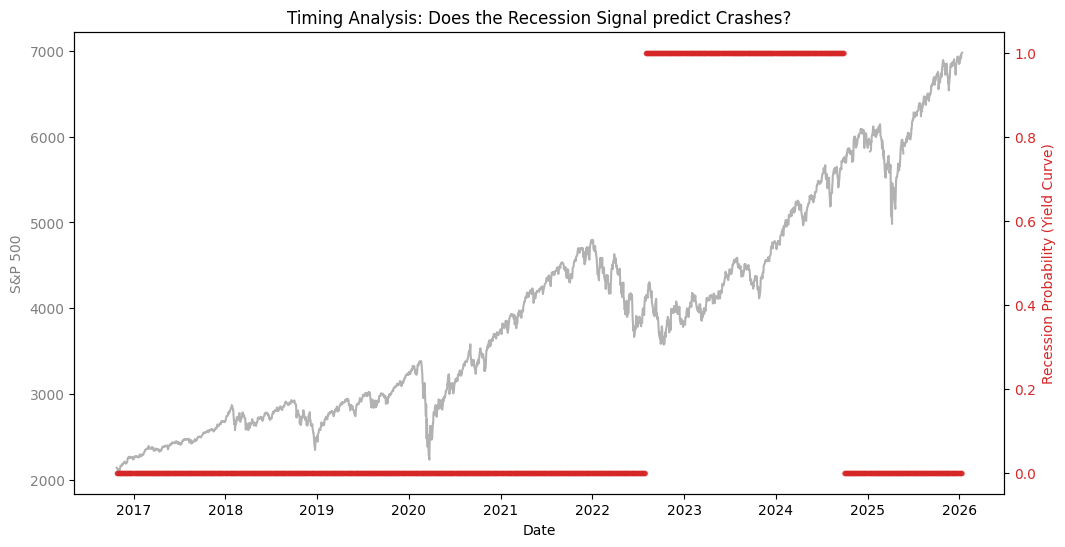

In [24]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:gray'
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500', color=color)
ax1.plot(master_df.index, master_df['SP500'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Recession Probability (Yield Curve)', color=color)  
ax2.plot(master_df.index, master_df['Signal_Recession'], color=color, alpha=0.3, linestyle='None', marker='.')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Timing Analysis: Does the Recession Signal predict Crashes?")
plt.show()